In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astroquery.jplhorizons import Horizons
import astropy.units as u
from astropy.time import Time
plt.rcParams['figure.figsize'] = (7, 3.5)

In [2]:
x = np.fromfile('SLIM_2024-01-19_14-51-51_38400SPS_corrected.c64', 'complex64')
t0 = np.datetime64('2024-01-19T14:51:51')
fs = 38400
NFFT = 4096
w = np.blackman(NFFT)
f = np.fft.fftshift(np.abs(np.fft.fft(w * x[:x.size//NFFT*NFFT].reshape(-1, NFFT)))**2, axes=1)
tf = t0 + (NFFT / fs * 1e9) * np.arange(f.shape[0]) * np.timedelta64(1, 'ns')
faxis = np.fft.fftshift(np.fft.fftfreq(NFFT, 1/fs))

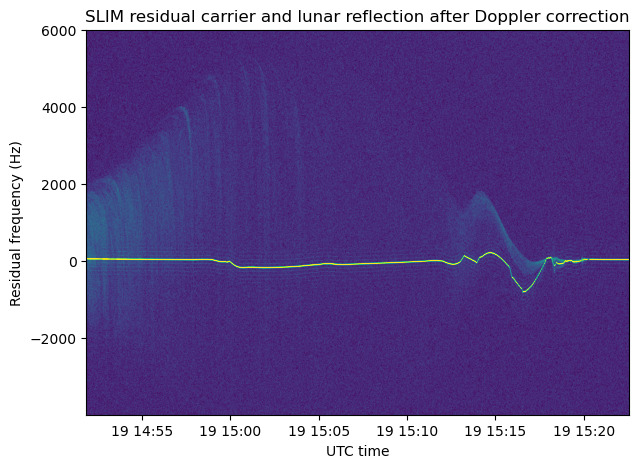

In [3]:
fsel = (faxis >= -4000) & (faxis <= 6000)
plt.figure(figsize=(7, 5))
plt.imshow(10*np.log10(f[:, fsel]).T[::-1], aspect='auto', vmin=-5, vmax=25,
           extent=[tf[0], tf[-1], faxis[fsel][0], faxis[fsel][-1]])
plt.xlabel('UTC time')
plt.ylabel('Residual frequency (Hz)')
plt.title('SLIM residual carrier and lunar reflection after Doppler correction');

In [4]:
x = np.fromfile('SLIM_2024-01-19_14-51-51_2400SPS_corrected.c64', 'complex64')
t0 = np.datetime64('2024-01-19T14:51:51')
fs = 2400

In [5]:
NFFT = 512
w = np.blackman(NFFT)
f = np.fft.fftshift(np.abs(np.fft.fft(w * x[:x.size//NFFT*NFFT].reshape(-1, NFFT)))**2, axes=1)
tf = t0 + (NFFT / fs * 1e9) * np.arange(f.shape[0]) * np.timedelta64(1, 'ns')
faxis = np.fft.fftshift(np.fft.fftfreq(NFFT, 1/fs))

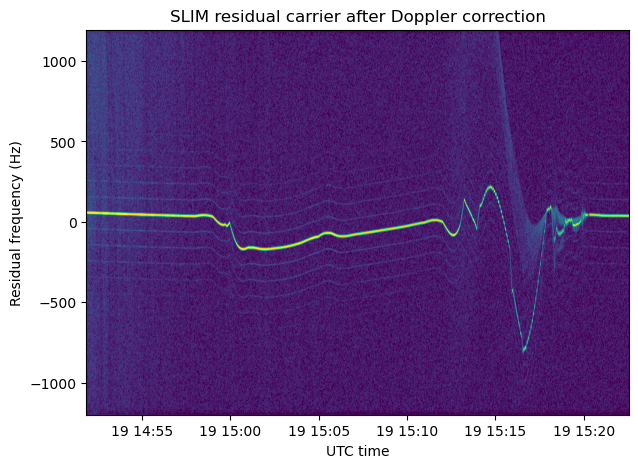

In [6]:
plt.figure(figsize=(7, 5))
plt.imshow(10*np.log10(f).T[::-1], aspect='auto', vmin=-25, vmax=15,
           extent=[tf[0], tf[-1], faxis[0], faxis[-1]])
plt.xlabel('UTC time')
plt.ylabel('Residual frequency (Hz)')
plt.title('SLIM residual carrier after Doppler correction');

In [7]:
fmax = faxis[np.argmax(f, axis=1)]
window = 2
pwr = np.empty(f.shape[0])
for j in range(f.shape[0]):
    a = np.argmax(f[j])
    pwr[j] = np.sum(f[j, a-window:a+window+1])
pwr /= np.average(pwr)

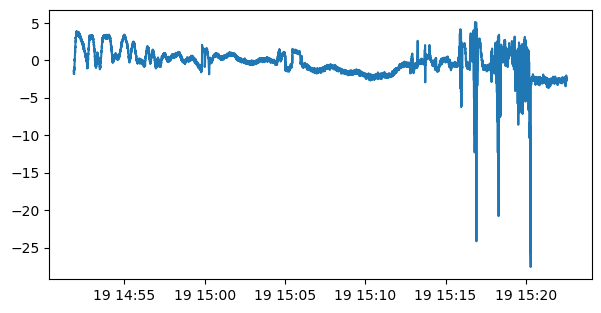

In [8]:
plt.plot(tf, 10*np.log10(pwr))
fmax[10*np.log10(pwr) < -20] = np.nan

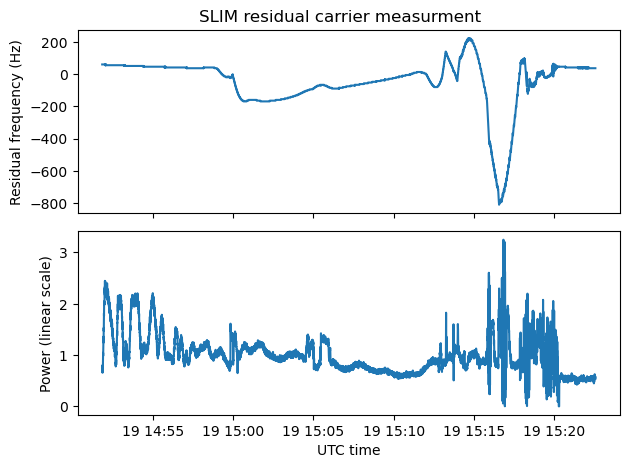

In [9]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7, 5))
axs[0].plot(tf, fmax)
axs[1].plot(tf, pwr)
plt.subplots_adjust(hspace=0.1)
axs[1].set_xlabel('UTC time')
axs[0].set_ylabel('Residual frequency (Hz)')
axs[1].set_ylabel('Power (linear scale)')
plt.suptitle('SLIM residual carrier measurment', y=0.92);

In [10]:
query = Horizons(
    id='SLIM', location='500@301', # Moon body center
    epochs={'start': '2024-01-19T14:30:00', 'stop': '2024-01-19T15:30:00', 'step': '3600'},
)
vectors = query.vectors()

In [11]:
tv = (1e9 * Time(vectors['datetime_jd'], format='jd', scale='tdb').unix) * np.timedelta64(1, 'ns') + np.datetime64('1970-01-01T00:00')
tvsel = (tv >= tf[0]) & (tv <= tf[-1])
r = np.array([vectors[ax].to(u.km) for ax in 'xyz']).T
rabs = np.sqrt(np.sum(r * r, axis=1))
lz_h = rabs[-1]
v = np.array([vectors[f'v{ax}'].to(u.m/u.s) for ax in 'xyz']).T
vabs = np.sqrt(np.sum(v * v, axis=1))
v_vert = np.sum(v * r, axis=1) / rabs
v_hor = np.sqrt(vabs**2 - v_vert**2)
v_angle = np.arcsin(v_vert / vabs)
accel = np.diff(v, axis=0)
accel_abs = np.sqrt(np.sum(accel**2, axis=-1))
GM_moon = 4902.8001 # km^3/s^2
grav_accel = -r * GM_moon/rabs[:, np.newaxis]**3 * 1e3  # m/s^2
grav_accel_abs = np.sqrt(np.sum(grav_accel**2, axis=-1))
nongrav_accel = accel - grav_accel[:-1]
nongrav_accel_abs = np.sqrt(np.sum(nongrav_accel**2, axis=-1))
nongrav_accel_v = np.sum(nongrav_accel * v[:-1], axis=1) / vabs[:-1]
nongrav_accel_vert = np.sum(nongrav_accel * r[:-1], axis=1) / rabs[:-1]
doppler0 = np.fromfile('SLIM-doppler-Bochum-2024-01-19.txt', sep=' ').reshape(-1, 2)
doppler1 = np.fromfile('SLIM-doppler-Usuda-2024-01-19.txt', sep=' ').reshape(-1, 2)
assert np.all(doppler0[:, 0] == doppler1[:, 0])
doppler = doppler0[:, 1] + doppler1[:, 1]
tdoppler = (1e9 * doppler0[:, 0]) * np.timedelta64(1, 'ns') + np.datetime64('1970-01-01T00:00')
tdopplersel = (tdoppler >= tf[0]) & (tdoppler <= tf[-1])

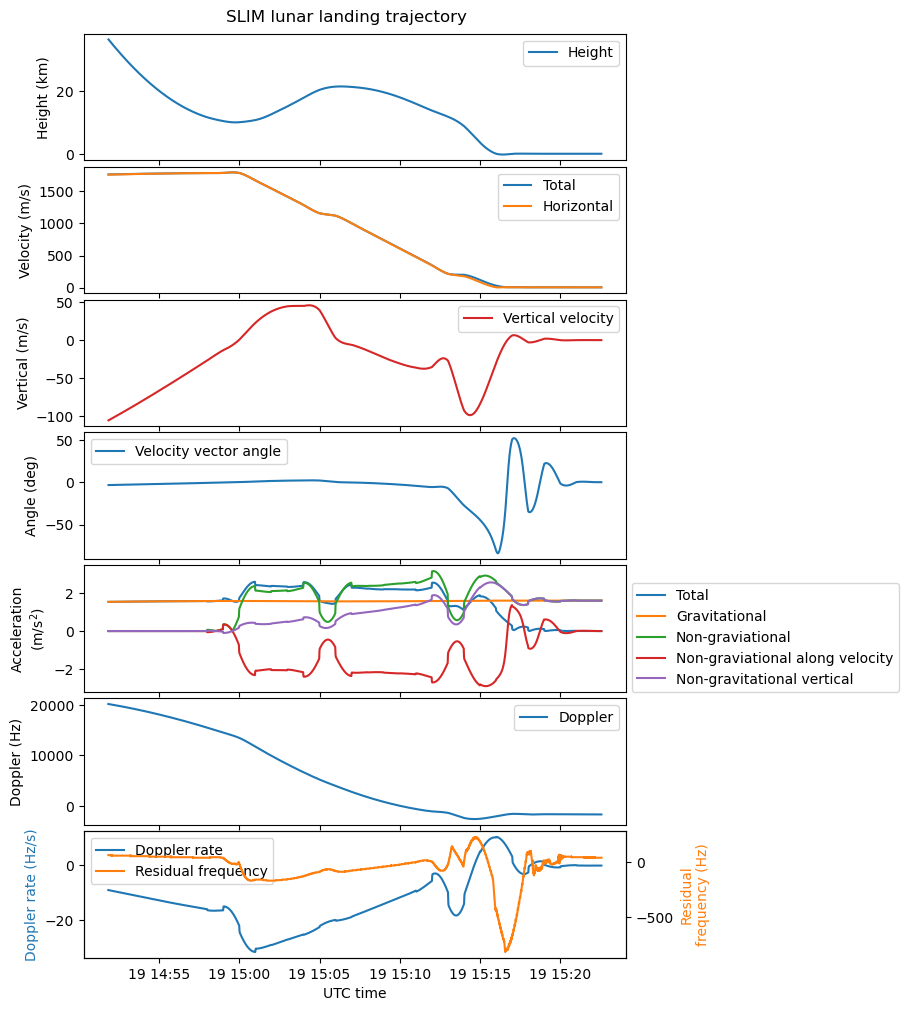

In [12]:
fig, axs = plt.subplots(7, 1, sharex=True, figsize=(7, 12))
axs[0].plot(tv[tvsel], rabs[tvsel] - lz_h)
axs[0].set_ylabel('Height (km)')
axs[0].legend(['Height'])
axs[1].plot(tv[tvsel], vabs[tvsel])
axs[1].plot(tv[tvsel], v_hor[tvsel])
axs[1].set_ylabel('Velocity (m/s)')
axs[1].legend(['Total', 'Horizontal'])
axs[2].plot(tv[tvsel], v_vert[tvsel], color='C3')
axs[2].set_ylabel('Vertical (m/s)')
axs[2].legend(['Vertical velocity'])
axs[3].plot(tv[tvsel], np.rad2deg(v_angle[tvsel]))
axs[3].set_ylabel('Angle (deg)')
axs[3].legend(['Velocity vector angle'])
axs[4].plot(tv[tvsel], accel_abs[tvsel[:-1]])
axs[4].plot(tv[tvsel], grav_accel_abs[tvsel])
axs[4].plot(tv[tvsel], nongrav_accel_abs[tvsel[:-1]])
axs[4].plot(tv[tvsel], nongrav_accel_v[tvsel[:-1]])
axs[4].plot(tv[tvsel], nongrav_accel_vert[tvsel[:-1]])
axs[4].set_ylabel('Acceleration\n(m/s$^2$)')
axs[4].legend(['Total', 'Gravitational', 'Non-graviational', 'Non-graviational along velocity', 'Non-gravitational vertical'],
              loc=[1.01, 0])
axs[5].plot(tdoppler[tdopplersel], doppler[tdopplersel])
axs[5].set_ylabel('Doppler (Hz)')
axs[5].legend(['Doppler'])
lns1 = axs[6].plot(tdoppler[tdopplersel], np.diff(doppler)[tdopplersel[:-1]])
axs[6].set_ylabel('Doppler rate (Hz/s)', color='C0')
ax2 = axs[6].twinx()
ax2.set_ylabel('Residual\nfrequency (Hz)', color='C1')
lns2 = ax2.plot(tf, fmax, color='C1')
lns = lns1 + lns2
axs[6].legend(lns, ['Doppler rate', 'Residual frequency'])
plt.subplots_adjust(hspace=0.05)
plt.suptitle('SLIM lunar landing trajectory', y=0.9)
axs[-1].set_xlabel('UTC time');